In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
sns.set_style("darkgrid")

In [3]:
data_path = '..\\Data\\'
# Read all files
sales            = pd.read_csv(data_path + 'sales_train.csv')
items            = pd.read_csv(data_path + 'items.csv')
item_categories  = pd.read_csv(data_path + 'item_categories_translated.csv')
shops            = pd.read_csv(data_path + 'shops_translated.csv')
test             = pd.read_csv(data_path + 'test.csv')

#Item_categories and Shops dfs are translated from the original russian files. 
#Translations are performed in Preprocessing/Translate.ipynb 

OBJETIVE: predict test.csv (data from November 2015)

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category


# Sales

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Text(0.5, 1.0, 'Item price')

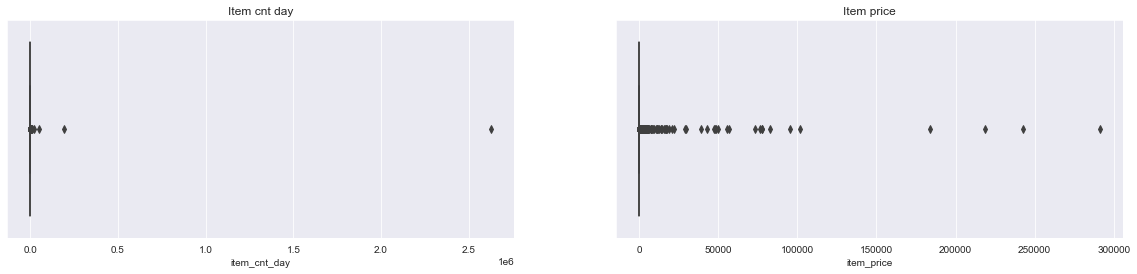

In [122]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.boxplot(sales.item_cnt_day.value_counts())
plt.title("Item cnt day")
plt.subplot(1,2,2)
sns.boxplot(sales.item_price.value_counts())
plt.title("Item price")

In [123]:
print(f"Min item_cnt_day: {sales.item_cnt_day.min()} | Max item_cnt_day: {sales.item_cnt_day.max()}")
print(f"Min price: {sales.item_price.min()}         | Max price: {sales.item_price.max()}")

Min item_cnt_day: -22.0 | Max item_cnt_day: 2169.0
Min price: -1.0         | Max price: 307980.0


* We have some outliers on target and on price

In [124]:
print(f"0 quantile item_cnt_day: {np.quantile(sales.item_cnt_day,0.01)} | 0.999 quantile item_cnt_day: {np.quantile(sales.item_cnt_day,0.999)}")
print(f"0 quantile price: {np.quantile(sales.item_price,0.01)}         | 0.999 quantile price: {np.quantile(sales.item_price,0.999)}")

0 quantile item_cnt_day: 1.0 | 0.999 quantile item_cnt_day: 22.0
0 quantile price: 5.0         | 0.999 quantile price: 23990.0


In [140]:
round(sales[sales.item_price>24000].shape[0]/sales.shape[0],4)*100

0.1

In [157]:
print(f"Lower outliers item_cnt_day: {sales[sales.item_cnt_day<0].shape[0]} > \
{round(sales[sales.item_cnt_day<0].shape[0]/sales.shape[0],4)*100}% of total DF \n\
Upper outliers item_cnt_day: {sales[sales.item_cnt_day>1000].shape[0]}")
print("-"*60)
print(f"Lower outliers price: {sales[sales.item_price<=0].shape[0]} \n\
Upper outliers price: {sales[sales.item_price>50000].shape[0]} > \
{round(sales[sales.item_price>50000].shape[0]/sales.shape[0],4)*100}% of total DF")

Lower outliers item_cnt_day: 7356 > 0.25% of total DF 
Upper outliers item_cnt_day: 1
------------------------------------------------------------
Lower outliers price: 1 
Upper outliers price: 3 > 0.0% of total DF


* Target values are concentrated in [0,20] range

In [72]:
sales = sales[(sales['item_price'] > 0) & (sales['item_price'] < 50000)]
sales = sales[(sales['item_cnt_day'] > 0) & (sales['item_cnt_day'] < 1000)]

Text(0.5, 1.0, 'Log Item price')

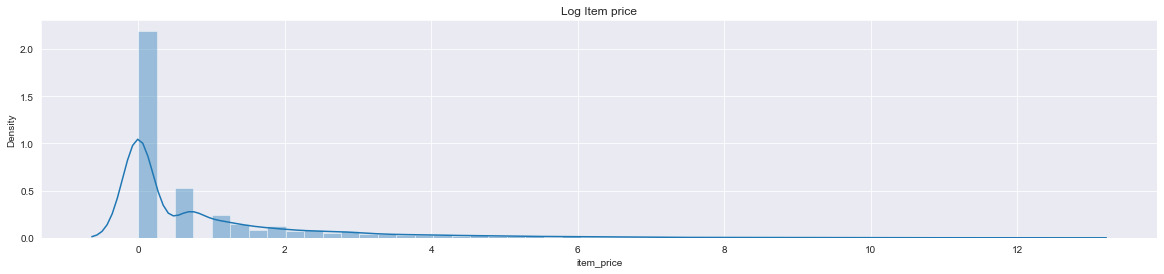

In [161]:
plt.figure(figsize=(20,4))
sns.distplot(np.log(sales.item_price.value_counts()))
plt.title("Log Item price")

Text(0.5, 1.0, 'Log Item cnt day')

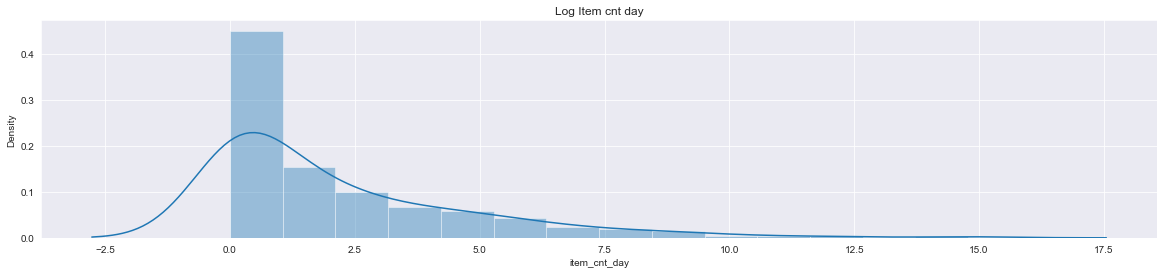

In [162]:
plt.figure(figsize=(20,4))
sns.distplot(np.log(sales.item_cnt_day.value_counts()))
plt.title("Log Item cnt day")

# Item Categories

In [31]:
item_categories.head()

,Unnamed: 0,item_category_name,item_category_id
0,0,PC - Headset / Headphones,0
1,1,Accessories - PS2.,1
2,2,Accessories - PS3,2
3,3,Accessories - PS4.,3
4,4,Accessories - PSP.,4


In [173]:
print(f"\nItem_category_name unique values: \
{item_categories.item_category_name.nunique()}\n"), item_categories.item_category_name.unique()[:20]


Item_category_name unique values: 84



(None, array(['PC - Headset / Headphones', 'Accessories - PS2.',
        'Accessories - PS3', 'Accessories - PS4.', 'Accessories - PSP.',
        'Accessories - Psvita.', 'Accessories - Xbox 360',
        'Accessories - Xbox One', 'Tickets (digit)', 'Delivery of goods',
        'Gaming Consoles - PS2', 'Gaming Consoles - PS3',
        'Gaming Consoles - PS4', 'Gaming Consoles - PSP',
        'Gaming Consoles - Psvita', 'Gaming Consoles - Xbox 360',
        'Gaming Consoles - Xbox One', 'Gaming consoles - Other',
        'Games - PS2.', 'Games - PS3'], dtype=object))

* Seems we can create a "major" level to aggregate some categories

# Items

In [174]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [179]:
print(f"\nItems unique values: {items.item_id.nunique()}\n")


Items unique values: 22170



In [185]:
sales.groupby("item_id").size().sort_values()

item_id
0            1
7217         1
7219         1
7222         1
7234         1
         ...  
4181      6853
2808      7479
17717     9067
5822      9408
20949    31340
Length: 21807, dtype: int64

* We have several items that only have one appearence in Train set

# SHOPS

In [5]:
shops.head()

,Unnamed: 0,shop_name,shop_id
0,0,"! Yakutsk Ordzhonikidze, 56 fran",0
1,1,"! Yakutsk shopping center ""Central"" Fran",1
2,2,"Adygea shopping center ""Mega""",2
3,3,"Balashiha TRK ""October-Kinomir""",3
4,4,"Volzhsky shopping center ""Volga Mall""",4


In [24]:
shops.shop_name.unique()[20:40]

array(['Moscow "Sale"', 'Moscow MTRC "AFI MALL"', 'Moscow Shop C21',
       'Moscow TK "Budenovsky" (Pav.A2)',
       'Moscow TK "Budenovsky" (Pav.K7)', 'Moscow TRK "Atrium"',
       'Moscow TC "Area" (Belyaevo)', 'Moscow TC "Mega White Dacha II"',
       'Moscow TC "Mega Teply Stan" II',
       'Moscow shopping center "New Century" (Novokosino)',
       'Moscow TP "Perlovski"', 'Moscow TC "Semenovsky"',
       'Moscow shopping center "Silver House"', 'Mytishchi TRK "XL-3"',
       'N.Novgorod TK "Rio"', 'N.Novgorod TPC "Fantasy"',
       'Novosibirsk shopping center "Gallery Novosibirsk"',
       'Novosibirsk Tc "Mega"', 'Omsk Tc "Mega"',
       'Rostnone TRK "Megacentr Horizont"'], dtype=object)

<br>In most of the cases 1st word on the shops names is a city:
* Moscow
* Rostnone
* etc

We are going to create a new feature with the city of a shop <br><br><br> Also, there are some shops that appear to be the same one:
* "Zhukovsky st. Chkalova 39m²" --> "Zhukovsky st. Chkalova 39m?"
* "! Yakutsk Ordzhonikidze, 56 fran" --> "Yakutsk Ordzhonikidze, 56"
* "! Yakutsk shopping center "Central" Fran" --> "Yakutsk shopping center "Central"
* "Rostnone TRK "Megacentr Horizont" --> "Rostov on the Don TRK "Megcenter Horizon" island"


# TEST

In [186]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [199]:
print(f'Min n° of items of a Shop: {test.groupby("shop_id").size().min()}\n\
Max n° of items of a Shop: {test.groupby("shop_id").size().max()}')

Min n° of items of a Shop: 5100
Max n° of items of a Shop: 5100


In [200]:
test.groupby("item_id").size().sort_values().unique()

array([42], dtype=int64)

In [201]:
test.item_id.nunique()

5100

* Every Shop in the Test set has an instance for every 5100 items
* It seems that Test an LB dataset might be kind of a Cartesian Product between all the Shops and all the Items

# Sales trends

<AxesSubplot:xlabel='date_block_num'>

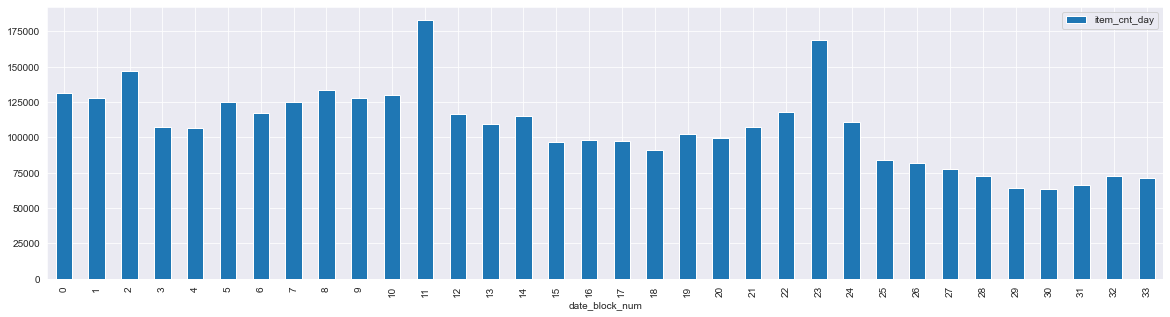

In [207]:
sales.groupby("date_block_num").agg({"item_cnt_day":"sum"}).plot(kind="bar", figsize=(20,5))

* There seems to be some kind of estationality on December